In [1]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats
from src.SERS_dataset import IterDataset, SERSDataset, SERSDatasetNPY
from src.generate_data2 import pseudoVoigtSimulatorTorch
# import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

c:\Users\andre\OneDrive - Danmarks Tekniske Universitet\Bachelorprojekt\Code\bachelor-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
def plot_loss(epoch, epochs, loss, loss_kl, loss_recon, z, x, recons, recons_mu, mu, logvar, labels, label_name, tmp_img="plots_vae_temp.png"):
    """ Plot the loss over time
    
    Args:
        loss (list): The loss over time

    Returns:
        None
    """
    x = x.to('cpu').detach().numpy()
    recons = recons.to('cpu').detach().numpy()
    recons_mu = recons_mu.to('cpu').detach().numpy()
    mu = mu.to('cpu').detach().numpy()
    logvar = logvar.to('cpu').detach().numpy()
    sigma = np.exp(0.5*logvar)
    z = z.to('cpu').detach().numpy()

    width = 3

    if len(labels) == 2:
        width = 4
    fig, axs = plt.subplots(3, width, figsize=(15, 15))

    # Figure title above all subplots
    fig.suptitle(f"Epoch {epoch} of {epochs}")

    # Plot loss
    axs[0, 0].plot(loss, label="Total loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_kl, label = "beta KL loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_recon, label = "Reconstruction loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].set_title("Train loss")
    axs[0, 0].legend()

    # make latent space scatter plot with colorbar for labels
    lab = labels[0].detach().cpu().numpy()
    sc = axs[0, 1].scatter(z[:, 0], z[:, 1], c=lab, cmap='viridis')
    cbar = fig.colorbar(sc, ax=axs[0, 1])
    axs[0, 1].set_title(f'Latent space, {len(lab)} samples')
    # axis labels
    axs[0, 1].set_xlabel('$z_0$')
    axs[0, 1].set_ylabel('$z_1$')  
    text_cbar = f'$\\{label_name[0]}$' if label_name[0] != 'c' else label_name[0]
    cbar.set_label(text_cbar, rotation=270-180)
    cbar.ax.yaxis.set_label_coords(-1, 0.5)
    

    if width == 4:
        # make latent space scatter plot with colorbar for labels
        lab = labels[1].detach().cpu().numpy()
        sc = axs[0, 2].scatter(z[:, 0], z[:, 1], c=lab, cmap='viridis')
        cbar = fig.colorbar(sc, ax=axs[0, 2])
        axs[0, 2].set_title(f'Latent space, {len(lab)} samples')
        # axis labels
        axs[0, 2].set_xlabel('$z_0$')
        axs[0, 2].set_ylabel('$z_1$')  
        text_cbar = f'$\\{label_name[1]}$' if label_name[1] != 'c' else label_name[1]
        cbar.set_label(text_cbar, rotation=270-180)
        cbar.ax.yaxis.set_label_coords(-1, 0.5)
        
        # lab = lab[lab.argsort()]
        # make colors for the scatter plot
        sc = axs[0, 3].scatter(z[:, 0], z[:, 1])
        # Hide sc
        sc.set_visible(False)
        axs[0, 3].set_title('Latent space, $2\\sigma$ from $\\mu$')
        # axis labels
        axs[0, 3].set_xlabel('$z_0$')
        axs[0, 3].set_ylabel('$z_1$')  

        mu_sorted = mu[lab.flatten().argsort()]
        sigma_sorted = sigma[lab.flatten().argsort()]
        # plot ellipses 
        for i in range(len(mu)):
            # get mean and std of the latent space
            mean = mu_sorted[i]
            std = sigma_sorted[i]
            # get the angle of the ellipse
            angle = np.arctan(std[1]/std[0])
            # get the width and height of the ellipse
            width_ellipse = 2*std[0]
            height_elipse = 2*std[1]
            # create the ellipse

            ellipse = matplotlib.patches.Ellipse(xy=mean, width=width_ellipse, height=height_elipse, angle=angle, alpha=0.5)
            # add the ellipse to the plot
            axs[0, 3].add_patch(ellipse)
    else:
        sc = axs[0, 2].scatter(z[:, 0], z[:, 1], c=lab, cmap='viridis')
        cbar = fig.colorbar(sc, ax=axs[0, 2])
        # Hide sc
        sc.set_visible(False)
        axs[0, 2].set_title('Latent space, $2\\sigma$ from $\\mu$')
        # axis labels
        axs[0, 2].set_xlabel('$z_0$')
        axs[0, 2].set_ylabel('$z_1$')  
        # Give colorbar a rotated text 
        text_cbar = f'$\\{label_name[0]}$' if label_name[0] != 'c' else label_name[0]
        cbar.set_label(text_cbar, rotation=270-180)
        cbar.ax.yaxis.set_label_coords(-1, 0.5)

        mu_sorted = mu[lab.flatten().argsort()]
        sigma_sorted = sigma[lab.flatten().argsort()]
        # lab = lab[lab.argsort()]
        # make colors for the scatter plot
        colors = plt.cm.viridis(np.linspace(0, 1, len(lab)))

        # plot ellipses 
        for i in range(len(mu)):
            # get mean and std of the latent space
            mean = mu_sorted[i]
            std = sigma_sorted[i]
            # get the angle of the ellipse
            angle = np.arctan(std[1]/std[0])
            # get the width and height of the ellipse
            width_ellipse = 2*std[0]
            height_elipse = 2*std[1]
            # create the ellipse

            ellipse = matplotlib.patches.Ellipse(xy=mean, width=width_ellipse, height=height_elipse, angle=angle, alpha=0.5, color=colors[i])
            # add the ellipse to the plot
            axs[0, 2].add_patch(ellipse)


    colors = plt.cm.rainbow(np.linspace(0, 1, len(mu[0])))
    for j in range(width):
        axs[1, j].plot(x[j].flatten(), label="Original")
        axs[1, j].plot(recons[j].flatten(), label="Reconstruction")
        axs[1, j].plot(recons_mu[j].flatten(), label="Reconstruction mu")
        axs[1, j].set_title("Reconstruction of SERS spectra")
        axs[1, j].set_ylabel("Intensity (a.u.)")
        axs[1, j].legend()

        for i in range(len(mu[0]-1)):
            axs[2, j].axvline(mu[j][i], linestyle='--', alpha=0.5, color=colors[i])
            linsp = np.linspace(np.min(mu[j])-sigma[j][np.argmin(mu[j])]*3, np.max(mu[j])+sigma[j][np.argmax(mu[j])]*3, 100)
            axs[2, j].plot(linsp, stats.norm.pdf(linsp, mu[j][i], sigma[j][i]), label="Normal distribution", color=colors[i])
            axs[2, j].plot(z[j][i], 0, 'o', color=colors[i], alpha=0.5)
            axs[2, j].set_title("Latent space")
        

    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


In [4]:

class Autoencoder(nn.Module):
    """ The autoencoder is a combination of the encoder and decoder
    
    Args:
        encoder (nn.Module): The encoder to use
        decoder (nn.Module): The decoder to use
        latent_dims (int): The number of latent dimensions to use
    """
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()

        self.encoder1 = nn.Linear(in_features=500, out_features=128).to(device)
        self.encoder2 = nn.ReLU().to(device)
        self.encoder_mu = nn.Linear(in_features=128, out_features=latent_dims).to(device)
        self.encoder_logvar = nn.Linear(in_features=128, out_features=latent_dims).to(device)


        self.decoder1 = nn.Linear(in_features=latent_dims, out_features=128).to(device)
        self.decoder2 = nn.ReLU().to(device)
        self.decoder3 = nn.Linear(in_features=128, out_features=500).to(device)

        self.kl = 0


    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        mu = self.encoder_mu(h2)
        logvar = self.encoder_logvar(h2)
        # torch rsample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        
        return z, mu, logvar     
    
    def decode(self, z):
        h1 = self.decoder1(z)
        h2 = self.decoder2(h1)
        return self.decoder3(h2)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        return self.decode(z)

In [93]:
def train(autoencoder, data, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, beta=1, label = "alpha"):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=lr)

    # The loss function is defined
    loss_function = nn.MSELoss()

    # Lists to store the loss values
    train_loss = []
    test_loss = []
    train_loss_kl = []
    test_loss_kl = []
    train_loss_recon = []
    test_loss_recon = []

    x_test, y_test = next(iter(test_loader))


    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        batch_loss_kl = []
        batch_loss_recon = []
        valid_loss = []
        valid_loss_kl = []
        valid_loss_recon = []        
        # Loop through batches of train data
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            recon_loss = loss_function(x_hat, x)
            # recon_loss = (x - x_hat).pow(2).mean(axis=1).mean()
            kl = autoencoder.kl * beta

            loss = recon_loss + kl
            loss.backward()
            opt.step()

            batch_loss.append(loss.item())
            batch_loss_kl.append(kl.item())
            batch_loss_recon.append(recon_loss.item())
            if num_iterations_per_epoch and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))
        train_loss_kl.append(np.mean(batch_loss_kl))
        train_loss_recon.append(np.mean(batch_loss_recon))
        # print("train_loss: ", np.mean(batch_loss), "train_loss_KL: ", np.mean(batch_loss_kl), "train_loss_recon: ", np.mean(batch_loss_recon))

        
        # wandb.log({"train_loss": np.mean(batch_loss), "train_loss_KL": np.mean(batch_loss_kl), "train_loss_recon": np.mean(batch_loss_recon)})
 
        with torch.no_grad():
            autoencoder.eval()
            x, y = next(iter(data))
            x = x.to(device)
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)
            x_hat_mu = autoencoder.decode(mu)

           
            ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
            labels = []
            if isinstance(label, list):
                for l in label:
                    labels.append(y[:,ll[l]])
            else:
                labels.append(y[:,ll[label]])
                label = [label]


        if epoch % 9 == 0:
            plot_loss(epoch+1, epochs, train_loss, train_loss_kl, train_loss_recon, z, x, x_hat, x_hat_mu, mu, logvar, labels, label)
        # print("test_loss: ", np.mean(valid_loss), "test_loss_KL: ", np.mean(valid_loss_kl), "test_loss_recon: ", np.mean(valid_loss_recon))
        # wandb.log({"test_loss": np.mean(valid_loss), "test_loss_KL": np.mean(valid_loss_kl), "test_loss_recon": np.mean(valid_loss_recon)})

    return autoencoder, train_loss, test_loss

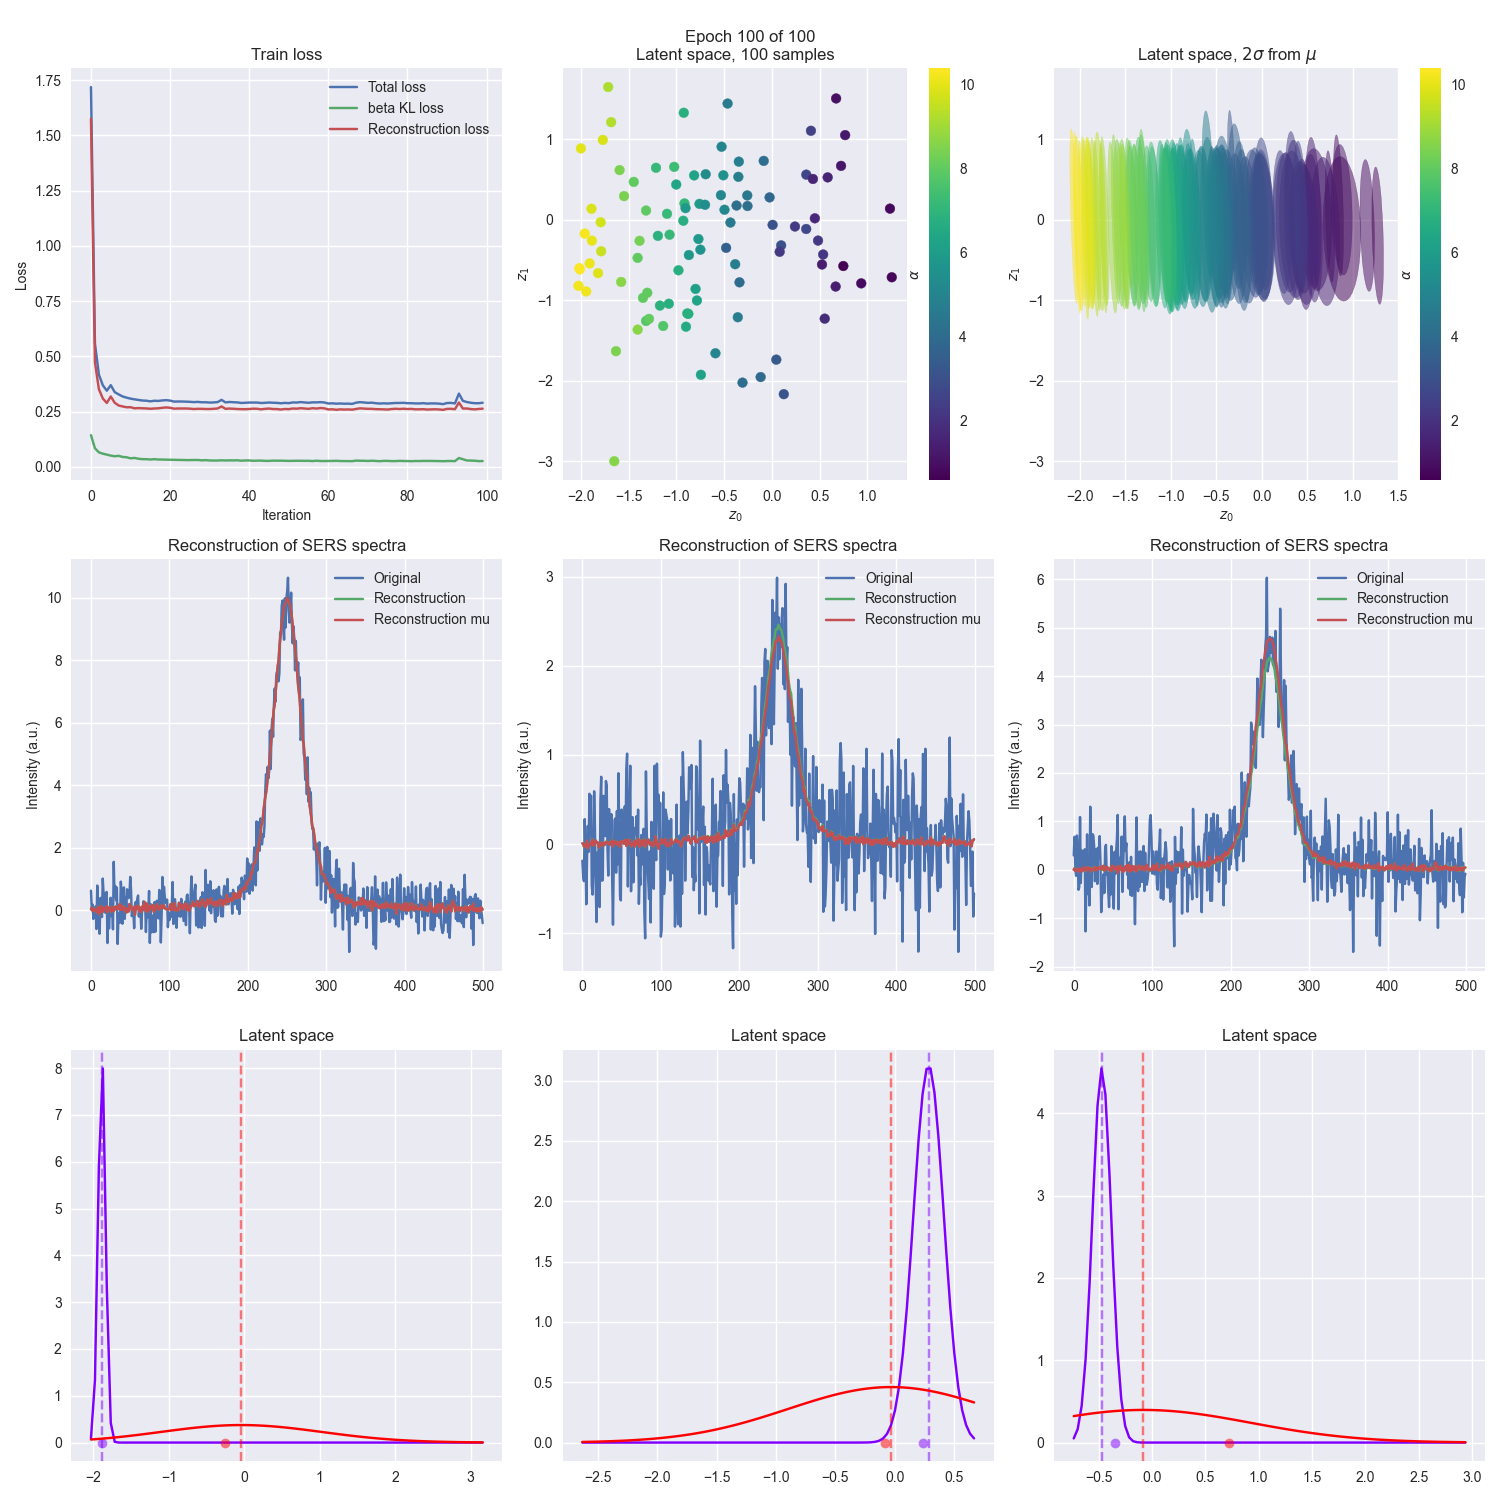

In [106]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-2
optimizer = "adam"


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = Autoencoder(latent_dims).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=0.01, label="alpha")


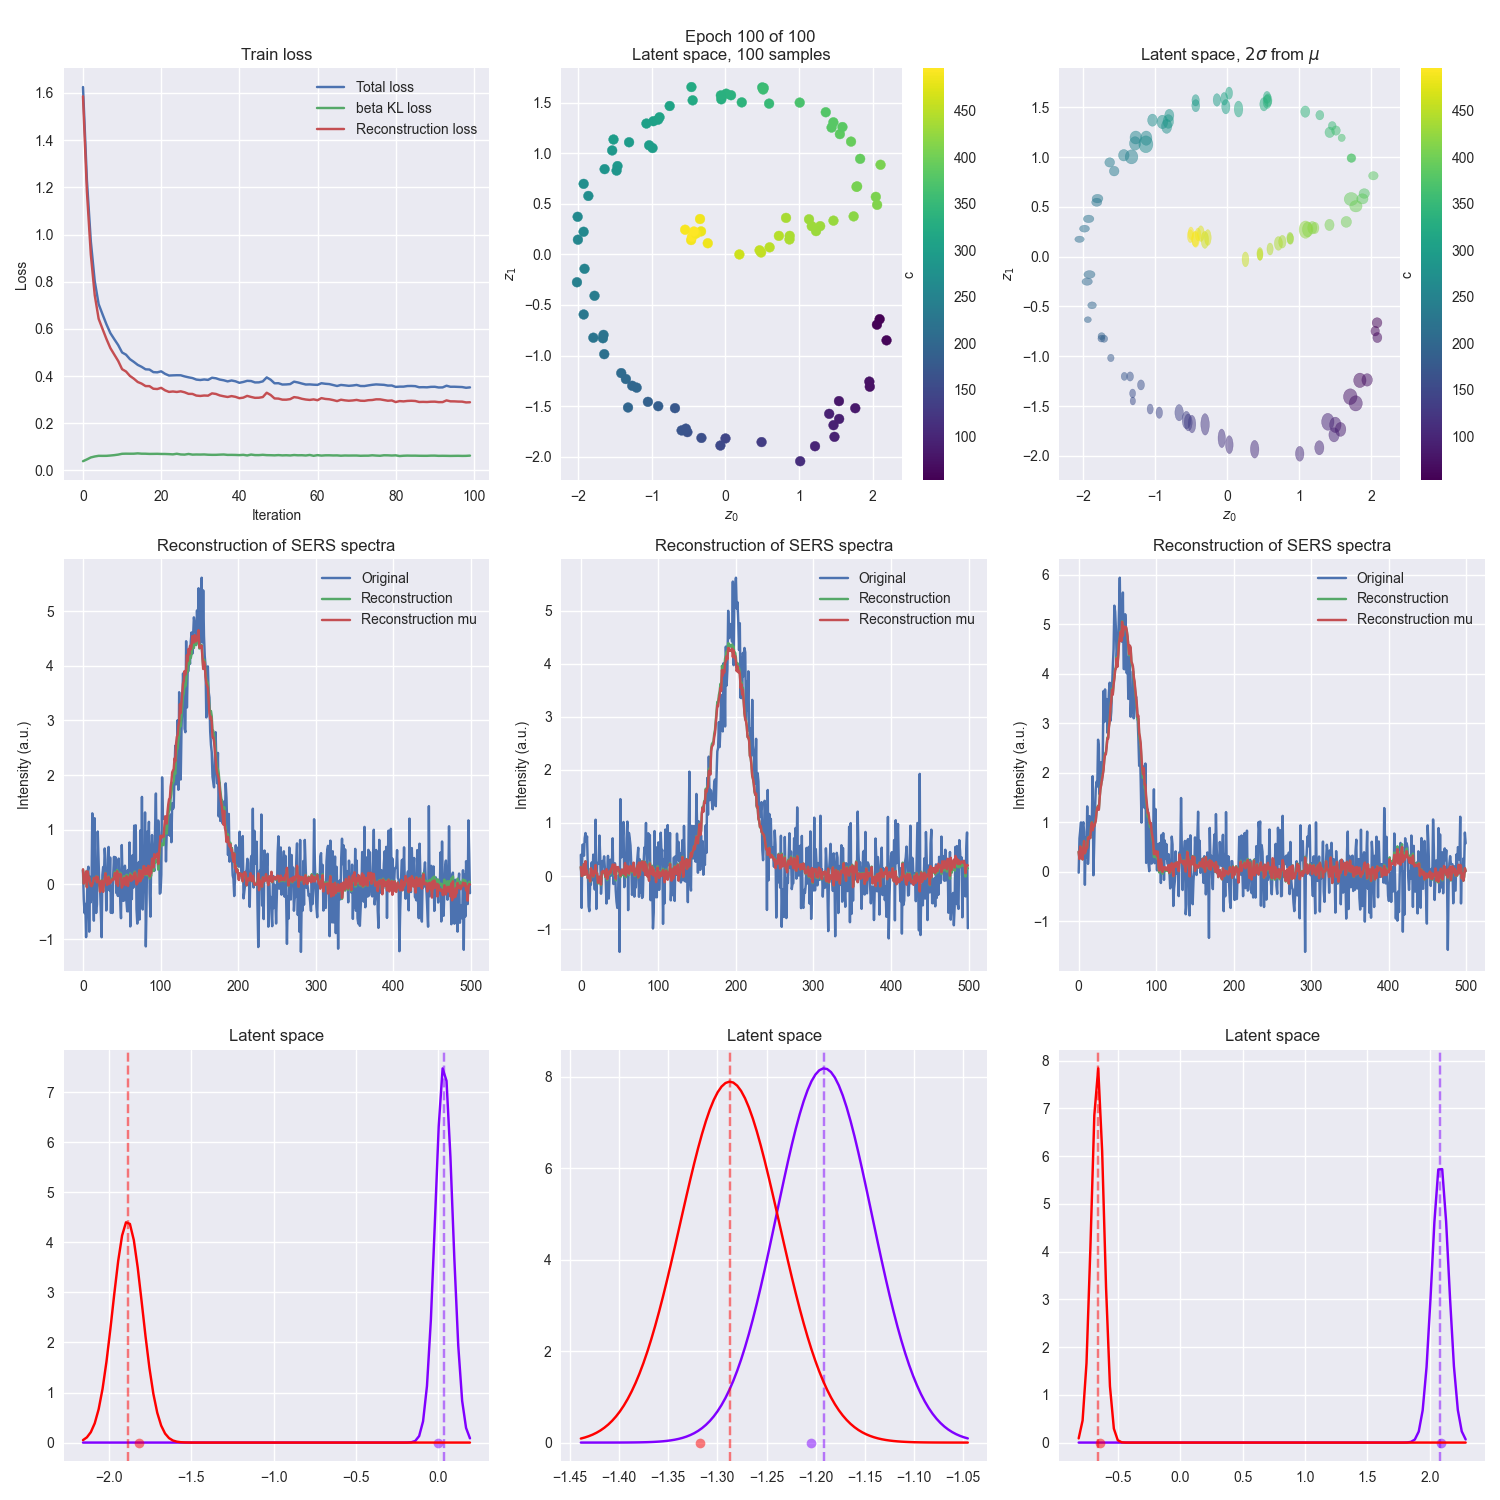

In [112]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-2
optimizer = "adam"


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), 
                         eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.5)

dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = Autoencoder(latent_dims).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=0.01, label="c")


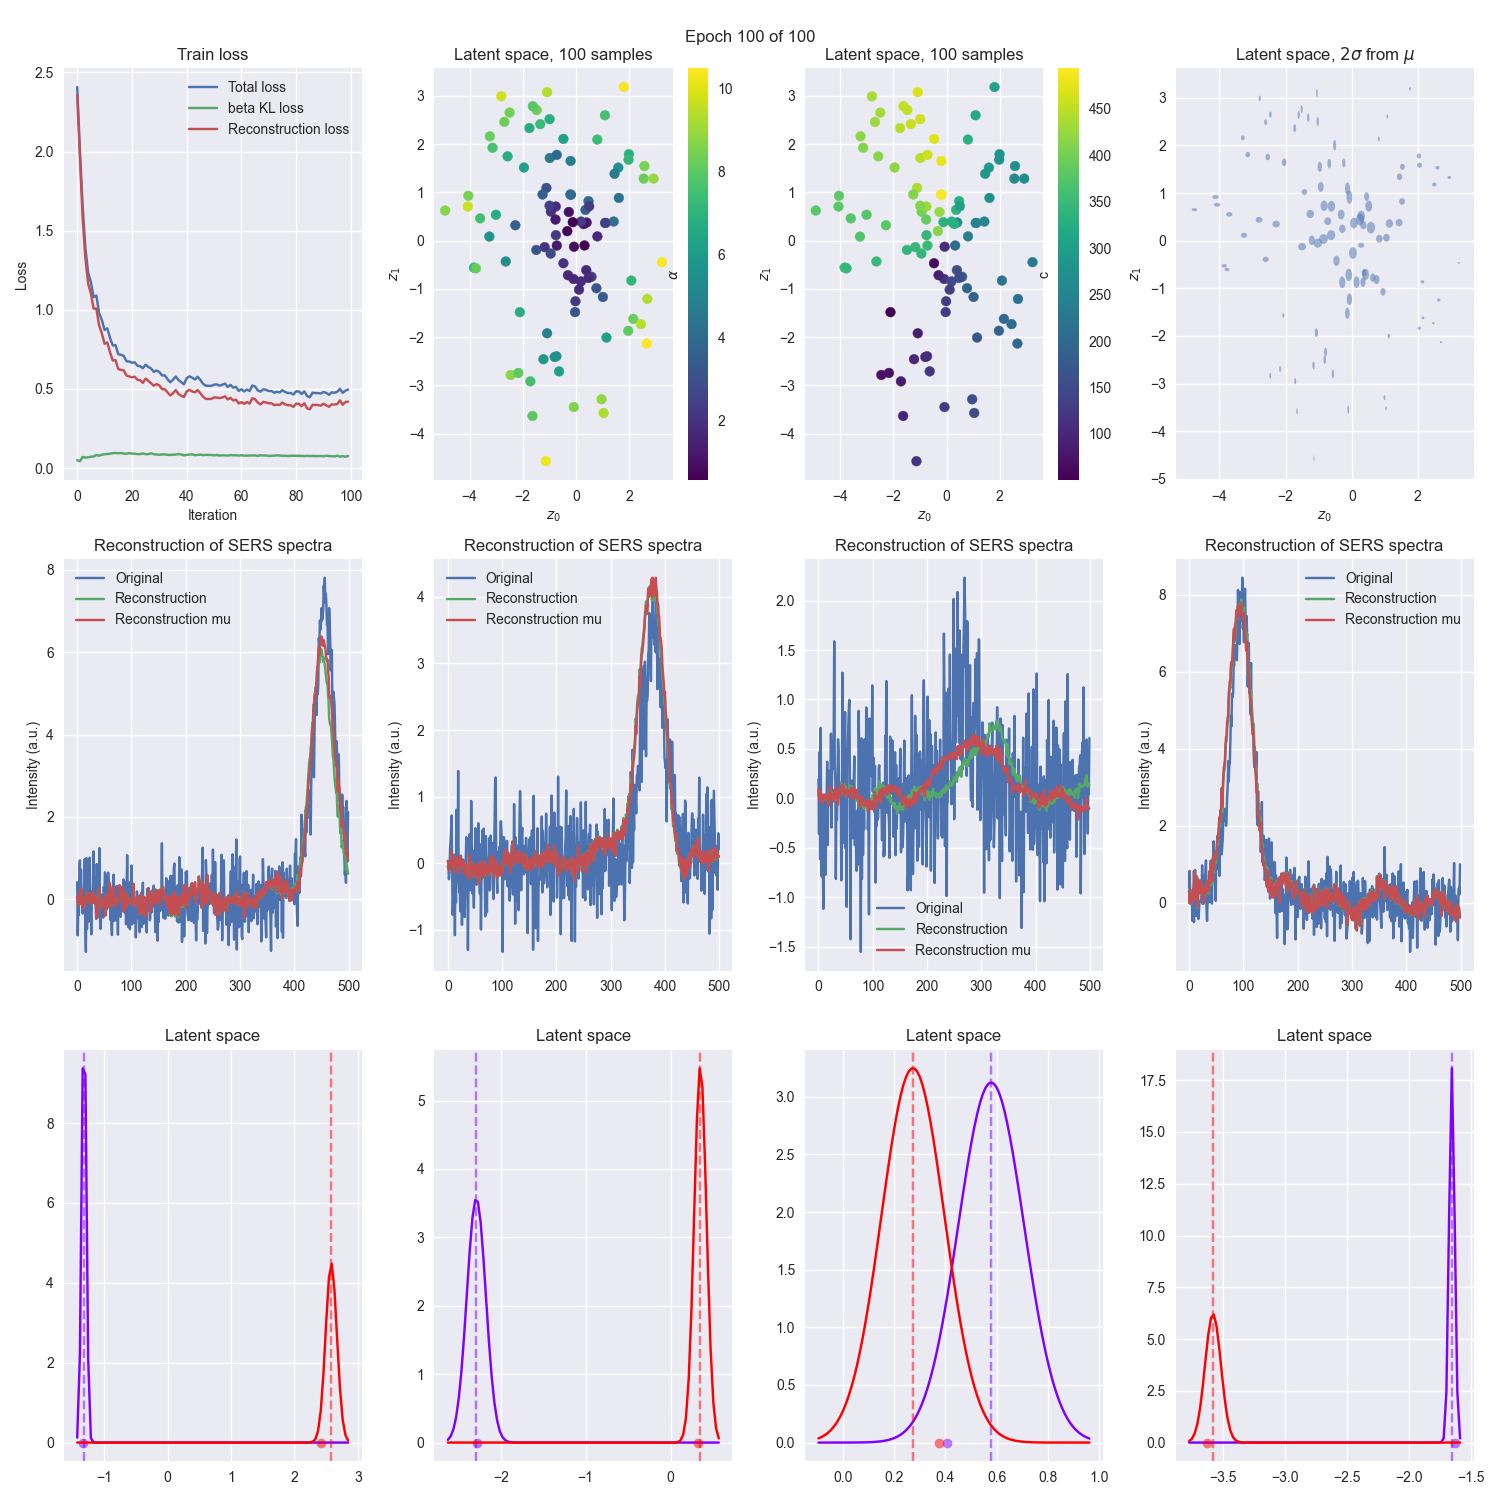

In [128]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-2
optimizer = "adam"


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), 
                         eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = Autoencoder(latent_dims).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=0.01, label=["alpha", "c"])


In [113]:

batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

x, y = next(iter(train_loader))


x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)


labels = [y[:,3]]



lab = labels[0].to('cpu').detach().numpy()
lab
mu

# sort mu and lab by lab
mu = mu.to('cpu').detach().numpy()
mu_sorted = mu[lab.flatten().argsort()]
lab = lab[lab.flatten().argsort()]

mu_sorted.shape, mu.shape
# mu[0].shape


# make colors for the scatter plot
# colors = plt.cm.viridis(lab.flatten())

# colors
# len(lab)

# alphas = []
# for alpha in lab:
#     alphas.append(alpha)

# print(len(alphas))
# # plot ellipses 
# for i in range(len(mu)):
#     # get mean and std of the latent space
#     mean = mu[i]
#     std = sigma[i]
#     # get the angle of the ellipse
#     angle = np.arctan(std[1]/std[0])
#     # get the width and height of the ellipse
#     width_ellipse = 2*std[0]
#     height_elipse = 2*std[1]
#     # create the ellipse
#     ellipse = matplotlib.patches.Ellipse(xy=mean, width=width_ellipse, height=height_elipse, angle=angle, alpha=0.5, color=colors[i])
#     # add the ellipse to the plot
#     axs[0, 1].add_patch(ellipse)

((100, 2), (100, 2))